## Final Project Preliminary EDA

In [1]:
# import libraries
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from sklearn.metrics import f1_score
import re as re
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from scipy import stats
from geopy.extra.rate_limiter import RateLimiter
import reverse_geocoder as rg
import seaborn as sns
sns.set(style = 'white')

In [2]:
# load the data and set strings = "NULL" for nan
train_2016 = pd.read_csv("train_2016_v2.csv", na_values = np.nan)
properties_2016 = pd.read_csv("properties_2016.csv", na_values = np.nan)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [3]:
# de-duplicate parcelids 
train_2016.drop_duplicates(subset = ['parcelid'], keep = False, inplace = True)
properties_2016.drop_duplicates(subset = ['parcelid'], keep = False, inplace = True)

In [4]:
# combine data sets and only keep labeled examples
train_2016_combo = pd.merge(train_2016, properties_2016, how = 'inner', on = 'parcelid')

# prep datagrame for geography data
train_2016_combo['latitude'] = train_2016_combo['latitude']/1e6
train_2016_combo['longitude'] = train_2016_combo['longitude']/1e6
train_2016_combo['latlng'] = train_2016_combo['latitude'].map(str) + ',' + train_2016_combo['longitude'].map(str)

In [5]:
# stripping transaction time with just dates
train_2016_combo['year_month'] = train_2016_combo['transactiondate'].apply(lambda x: str(x).strip()[0:7])

## Get City Data with Reverse Geocoder

https://github.com/thampiman/reverse-geocoder

In [7]:
# split the coordinates into tuples
coordinates = train_2016_combo["latlng"].apply(lambda x: tuple(x.split(',')))
results = rg.search(coordinates.tolist())

# write city and county names into lists
city = [result.get("name") for result in results]
county = [result.get("admin2") for reslt in results]

# add city and county columns in training dataframe
train_2016_combo["city"] = city
train_2016_combo["county"] = county


# Create July only dataframe

In [17]:
# filter the data to just December
mini_2016_train = train_2016_combo[train_2016_combo['year_month'] == '2016-07']

print(mini_2016_train.shape)
print(mini_2016_train['latlng'].head())
mini_2016_train.describe()

(9927, 64)
51597    34.066186,-118.457605
51598    34.190549,-118.522224
51599    34.171533,-118.427862
51600    34.150097,-118.847538
51601    34.189674,-118.580394
Name: latlng, dtype: object


,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,9.927000e+03,9927.000000,3218.000000,29.000000,2.000000,9927.000000,9927.000000,3.0,6377.000000,9855.000000,...,16.000000,9896.000000,2287.000000,9.918000e+03,9.927000e+03,9927.0,9.927000e+03,9926.000000,126.000000,9.910000e+03
mean,1.298546e+07,0.011711,1.890615,7.068966,361.500000,2.286693,3.060844,4.0,5.550102,2.302486,...,282.812500,1968.363783,1.460429,1.795364e+05,4.552555e+05,2015.0,2.758818e+05,5895.128987,12.738095,6.049228e+13
std,2.765177e+06,0.151775,3.102011,0.257881,174.655375,0.979622,1.124850,0.0,1.893173,0.964395,...,232.556006,23.870351,0.556583,2.146358e+05,5.167034e+05,0.0,3.612250e+05,6412.325142,1.935680,2.070312e+11
min,1.071186e+07,-2.688000,1.000000,7.000000,238.000000,0.000000,0.000000,4.0,1.000000,1.000000,...,37.000000,1885.000000,1.000000,1.000000e+03,8.314000e+03,2015.0,2.780000e+02,49.080000,7.000000,6.037101e+13
25%,1.153826e+07,-0.025300,1.000000,7.000000,299.750000,2.000000,2.000000,4.0,4.000000,2.000000,...,117.000000,1953.000000,1.000000,8.124825e+04,2.029920e+05,2015.0,8.311950e+04,2843.677500,12.000000,6.037311e+13
50%,1.254591e+07,0.005000,1.000000,7.000000,361.500000,2.000000,3.000000,4.0,7.000000,2.000000,...,234.000000,1970.000000,1.000000,1.320000e+05,3.423950e+05,2015.0,1.920780e+05,4488.020000,13.000000,6.037604e+13
75%,1.421821e+07,0.038300,1.000000,7.000000,423.250000,3.000000,4.000000,4.0,7.000000,3.000000,...,402.000000,1987.000000,2.000000,2.107235e+05,5.420085e+05,2015.0,3.438885e+05,6864.007500,14.000000,6.059042e+13
max,1.629607e+08,3.250000,13.000000,8.000000,485.000000,11.000000,16.000000,4.0,12.000000,11.000000,...,943.000000,2015.000000,3.000000,6.500000e+06,1.414969e+07,2015.0,1.154900e+07,159327.820000,15.000000,6.111009e+13


In [24]:
# look at the dataframe
mini_2016_train.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,latlng,year_month,city,county
51597,11647851,0.1151,2016-07-01,1.0,NaN,NaN,3.0,3.0,NaN,4.0,...,2015.0,895191.0,13918.93,NaN,NaN,6.037265e+13,"34.066186,-118.457605",2016-07,"Westwood, Los Angeles",Los Angeles County
51598,10778638,0.0010,2016-07-01,NaN,NaN,NaN,2.0,3.0,NaN,7.0,...,2015.0,41997.0,891.79,NaN,NaN,6.037133e+13,"34.190549,-118.522224",2016-07,Northridge,Los Angeles County
51599,10894627,0.0677,2016-07-01,NaN,NaN,NaN,3.0,3.0,NaN,4.0,...,2015.0,186245.0,4176.32,NaN,NaN,6.037125e+13,"34.171533,-118.427862",2016-07,Van Nuys,Los Angeles County
51600,17293779,-0.0377,2016-07-01,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,2015.0,443143.0,9979.54,NaN,NaN,6.111006e+13,"34.150097,-118.847538",2016-07,Thousand Oaks,Los Angeles County
51601,10794627,0.0286,2016-07-01,NaN,NaN,NaN,3.0,4.0,NaN,7.0,...,2015.0,130804.0,5586.05,NaN,NaN,6.037135e+13,"34.189674,-118.580394",2016-07,Canoga Park,Los Angeles County


## Preliminary Data Exploration

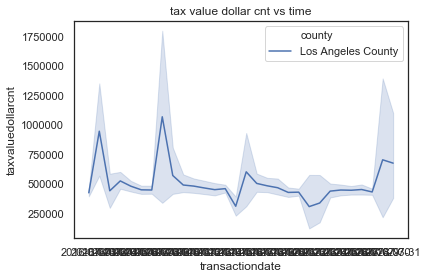

In [19]:
ax = sns.lineplot(x="transactiondate", 
                  y="taxvaluedollarcnt", 
                  hue="county", 
                  data=mini_2016_train).set_title('tax value dollar cnt vs time')


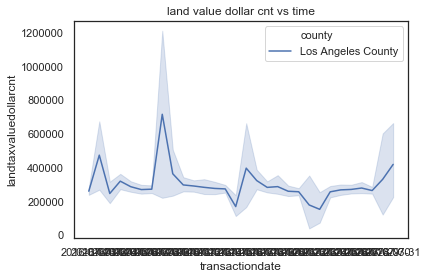

In [20]:
ax = sns.lineplot(x="transactiondate", 
                  y="landtaxvaluedollarcnt", 
                  hue="county", 
                  data=mini_2016_train).set_title('land value dollar cnt vs time')


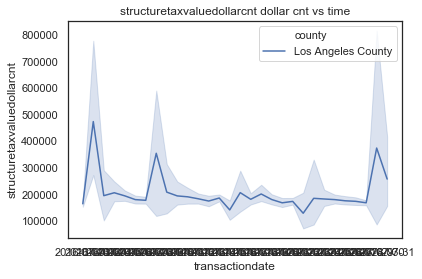

In [21]:
ax = sns.lineplot(x="transactiondate", 
                  y="structuretaxvaluedollarcnt", 
                  hue="county", 
                  data=mini_2016_train).set_title('structuretaxvaluedollarcnt dollar cnt vs time')


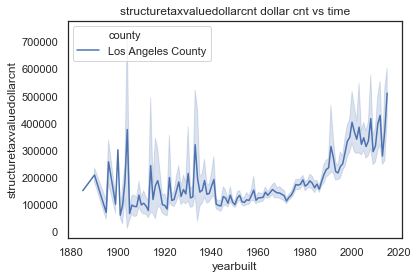

In [23]:
ax = sns.lineplot(x="yearbuilt", 
                  y="structuretaxvaluedollarcnt", 
                  hue="county", 
                  legend = 'brief', 
                  data=mini_2016_train).set_title('structuretaxvaluedollarcnt dollar cnt vs time')

plt.legend(loc='upper left')


## Discussion Questions

* Seems like there's some small differentiation between counties over time, so county should be a feature?
* Newer homes built have a higher value generally. OC and LA have the highest costs
* People who have delinquent tax years will live in a worse area usually.
* Interaction features between county*structuretaxvalue?
* Standardize structureprices by dividing by bathroomcount

## Potential Models

* linear regression since we are predicting logerror
* KNN because home prices in the same neighborhoods go up and down together